### 1. Data Preparation

In [432]:
import warnings
warnings.filterwarnings('ignore')

import momepy
import geopandas as gpd
import matplotlib.pyplot as plt
import osmnx as ox
import overpy
import geojson
import numpy as np
import libpysal
from shapely.geometry import LineString

In [344]:
gdf = ox.geometries.geometries_from_place('Marunouchi, Tokyo, Japan', tags={'building':True})
buildings = ox.projection.project_gdf(gdf)

buildings = buildings[buildings.geom_type == "Polygon"].reset_index(drop=True)
buildings = buildings[["geometry"]].to_crs("epsg:30176")
buildings["uID"] = range(len(buildings))

/Users/yutasato/opt/anaconda3/envs/gisenv/lib/python3.7/site-packages/osmnx/utils_geo.py:335: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  for polygon in geometry:
/Users/yutasato/opt/anaconda3/envs/gisenv/lib/python3.7/site-packages/osmnx/utils_geo.py:426: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  for poly in multipoly:
/Users/yutasato/opt/anaconda3/envs/gisenv/lib/python3.7/site-packages/osmnx/utils_geo.py:426: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  for poly in multipoly:


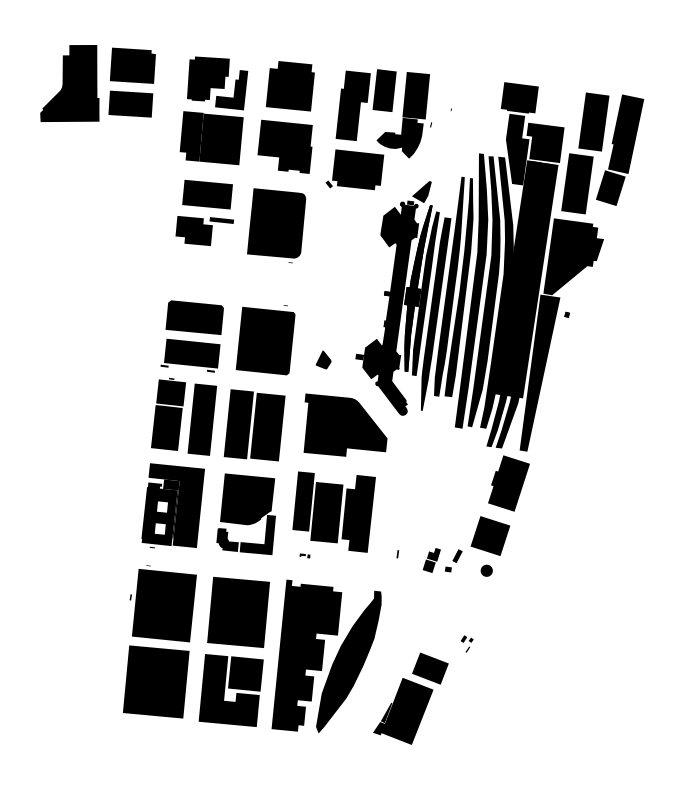

In [512]:
f, ax = plt.subplots(figsize=(10,10))
buildings.plot(ax=ax, color='black')
ax.set_axis_off()
plt.show()

In [362]:
osm_graph = ox.graph_from_place(query='Marunouchi, Tokyo, Japan',
                                network_type='all_private')

osm_graph = ox.projection.project_graph(osm_graph, to_crs="epsg:30176")
streets = ox.graph_to_gdfs(
    osm_graph,
    nodes=False,
    edges=True,
    node_geometry=False,
    fill_edge_geometry=True)

streets = momepy.remove_false_nodes(streets)
streets = streets[["geometry"]]
streets["nID"] = range(len(streets))

/Users/yutasato/opt/anaconda3/envs/gisenv/lib/python3.7/site-packages/osmnx/utils_geo.py:335: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  for polygon in geometry:
/Users/yutasato/opt/anaconda3/envs/gisenv/lib/python3.7/site-packages/osmnx/utils_geo.py:426: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  for poly in multipoly:
/Users/yutasato/opt/anaconda3/envs/gisenv/lib/python3.7/site-packages/osmnx/utils_geo.py:426: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  for poly in multipoly:


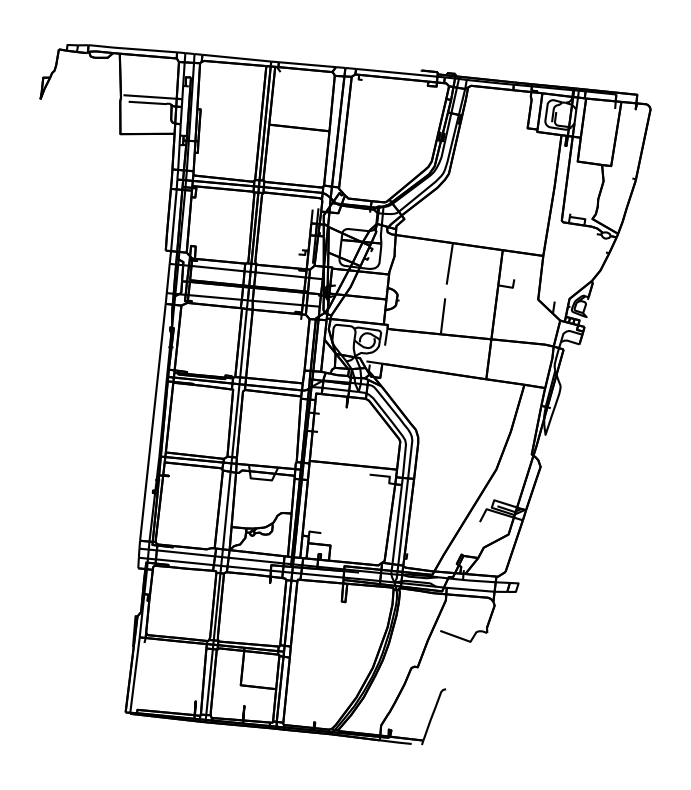

In [441]:
f, ax = plt.subplots(figsize=(10,10))

streets.plot(color="black", ax=ax)

ax.set_axis_off()
plt.show()

In [422]:
ox.config(log_console=True, use_cache=True)

osm_graph = ox.graph_from_place(query='Marunouchi, Tokyo, Japan',
                                network_type='all_private',
                                custom_filter = '["railway"~"rail"]')

osm_graph = ox.projection.project_graph(osm_graph, to_crs="epsg:30176")
railways = ox.graph_to_gdfs(
    osm_graph,
    nodes=False,
    edges=True,
    node_geometry=False,
    fill_edge_geometry=True)

railways = momepy.remove_false_nodes(railways)
railways = railways[["geometry"]]
railways["nID"] = range(len(railways))

2023-01-18 19:51:38 Configured OSMnx 1.1.1
2023-01-18 19:51:38 HTTP response caching is on
2023-01-18 19:51:38 Retrieved response from cache file "cache/5750d548af3f69cb29dc5744236f8473d23420da.json"
2023-01-18 19:51:38 Created GeoDataFrame with 1 rows from 1 queries
2023-01-18 19:51:38 Constructed place geometry polygon(s) to query API
2023-01-18 19:51:38 Projected GeoDataFrame to +proj=utm +zone=54 +ellps=WGS84 +datum=WGS84 +units=m +no_defs +type=crs
2023-01-18 19:51:38 Projected GeoDataFrame to epsg:4326
2023-01-18 19:51:38 Projected GeoDataFrame to +proj=utm +zone=54 +ellps=WGS84 +datum=WGS84 +units=m +no_defs +type=crs
2023-01-18 19:51:38 Projected GeoDataFrame to epsg:4326
2023-01-18 19:51:38 Requesting data within polygon from API in 1 request(s)
2023-01-18 19:51:38 Retrieved response from cache file "cache/24fcb7e00bdf6ca62efb6f5c6bab61ba33530004.json"
2023-01-18 19:51:38 Got all network data within polygon from API in 1 request(s)
2023-01-18 19:51:38 Creating graph from downl

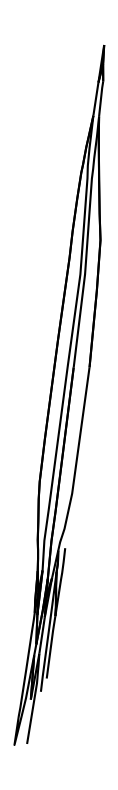

In [442]:
f, ax = plt.subplots(figsize=(10,10))

railways.plot(color="black", ax=ax)

ax.set_axis_off()
plt.show()

In [ ]:
streets_railways = gpd.overlay(streets, railways, how='union')

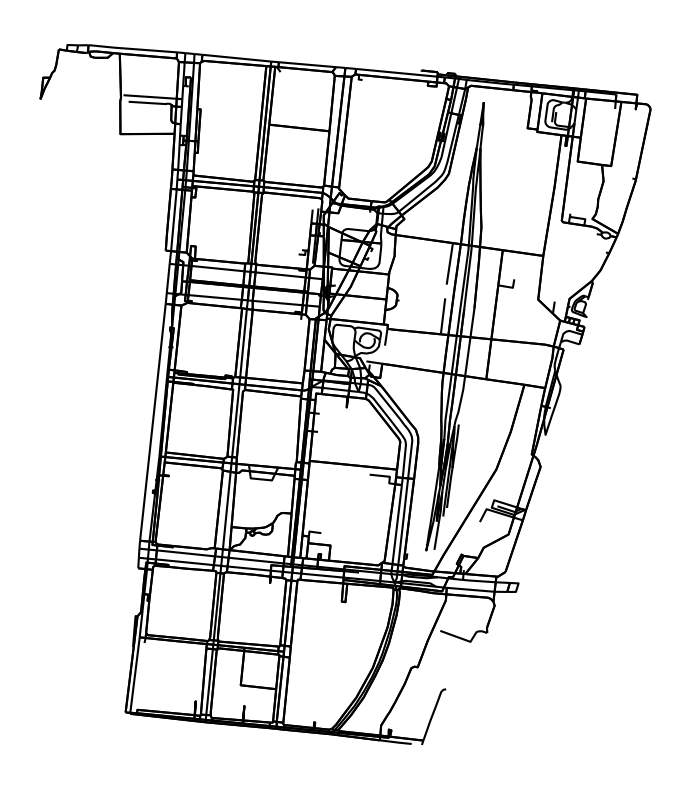

In [511]:
f, ax = plt.subplots(figsize=(10,10))

streets_railways.plot(color="black", ax=ax)

ax.set_axis_off()
plt.show()

### 2. Morphological Tessellation

In [443]:
limit = momepy.buffered_limit(buildings, 100)

tessellation = momepy.Tessellation(buildings, "uID", limit, segment=1)
tessellation = tessellation.tessellation

Inward offset...
Generating input point array...
Generating Voronoi diagram...
Generating GeoDataFrame...
Dissolving Voronoi polygons...


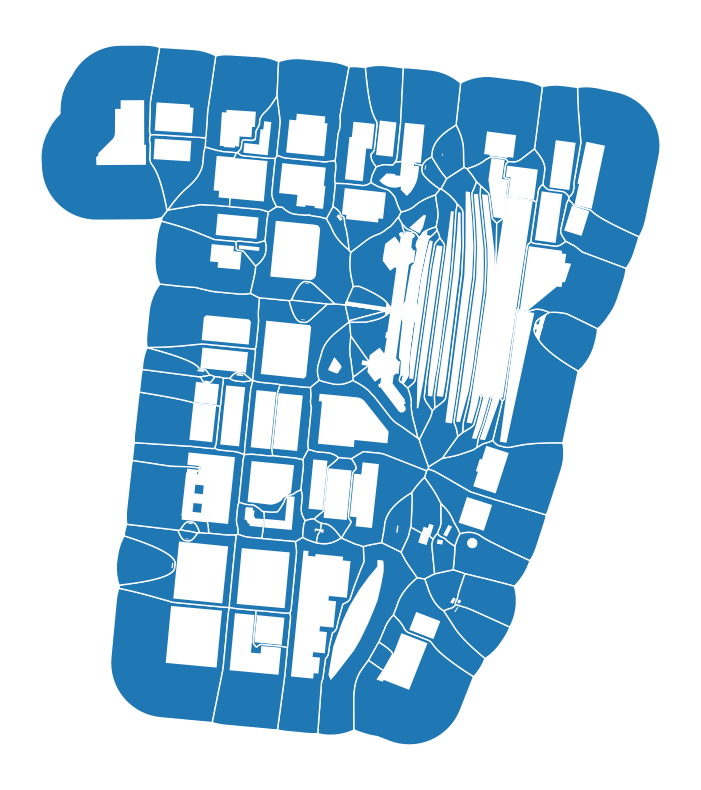

In [497]:
f, ax = plt.subplots(figsize=(10,10))

tessellation.plot(ax=ax, edgecolor="white", )
buildings.plot(color="white", ax=ax)

ax.set_axis_off()
plt.show()

### 3. Enclosed Tessellation

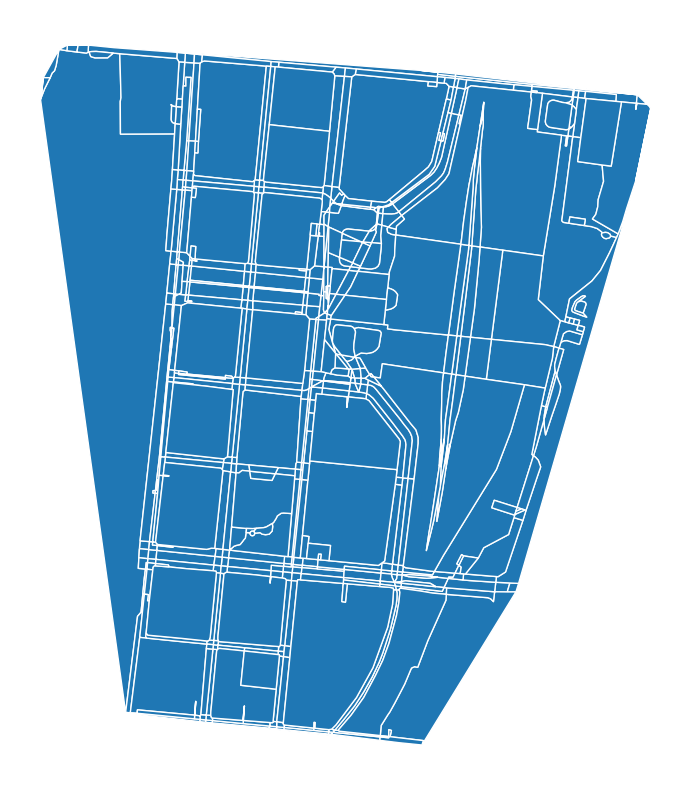

In [498]:
convex_hull = streets.unary_union.convex_hull
enclosures = momepy.enclosures(streets_railways, limit=gpd.GeoSeries([convex_hull]))

enclosures.plot(figsize=(10, 10), edgecolor='w').set_axis_off()

In [499]:
enclosed_tess = momepy.Tessellation(buildings, unique_id='uID', enclosures=enclosures).tessellation

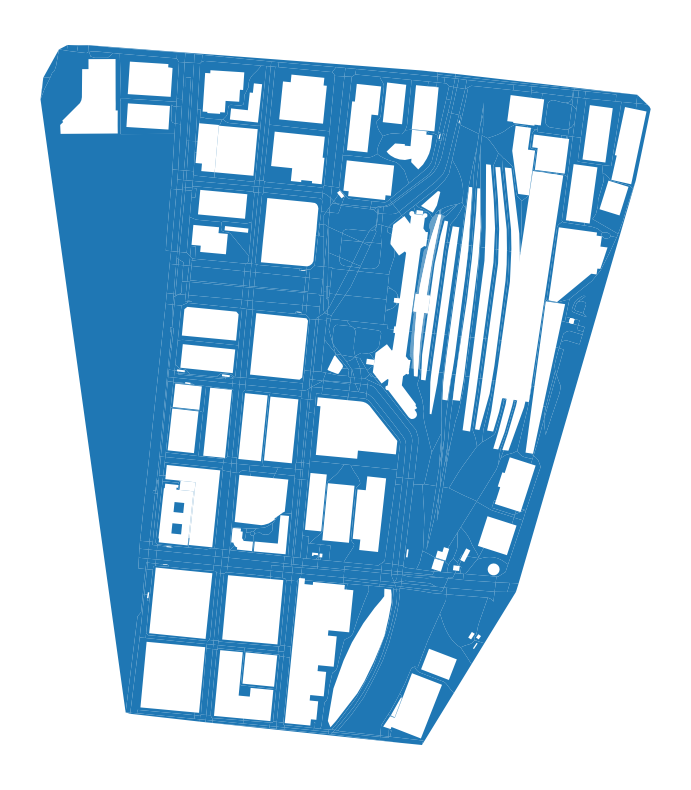

In [500]:
f, ax = plt.subplots(figsize=(10,10))

enclosed_tess.plot(ax=ax, )
buildings.plot(ax=ax, color="white")

ax.set_axis_off()

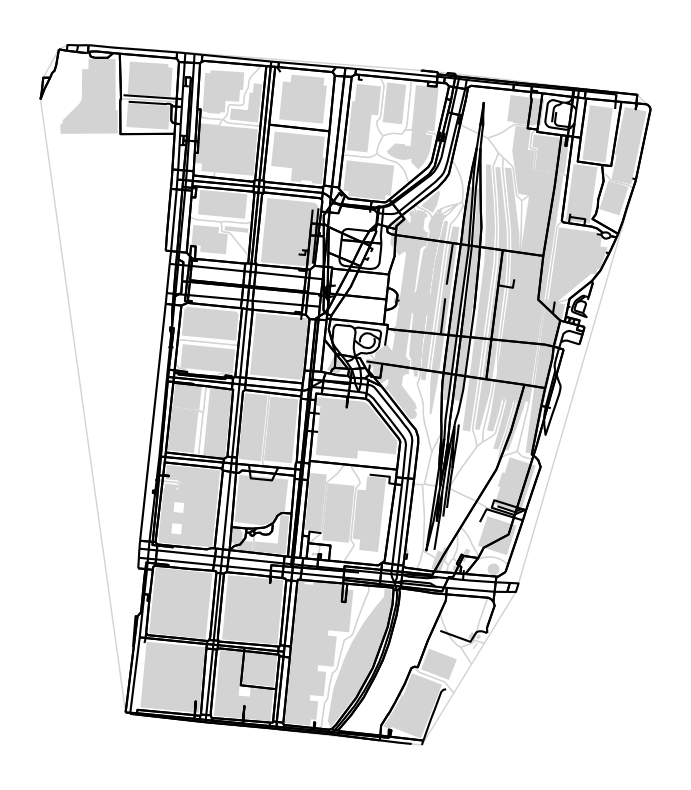

In [501]:
f, ax = plt.subplots(figsize=(10,10))

enclosed_tess.plot(ax=ax, color='white', edgecolor='lightgrey')
buildings.plot(ax=ax, color='lightgrey')
streets.plot(ax=ax, color='black')
railways.plot(ax=ax, color='black')

ax.set_axis_off()

In [502]:
w_queen = libpysal.weights.Queen.from_dataframe(enclosed_tess)

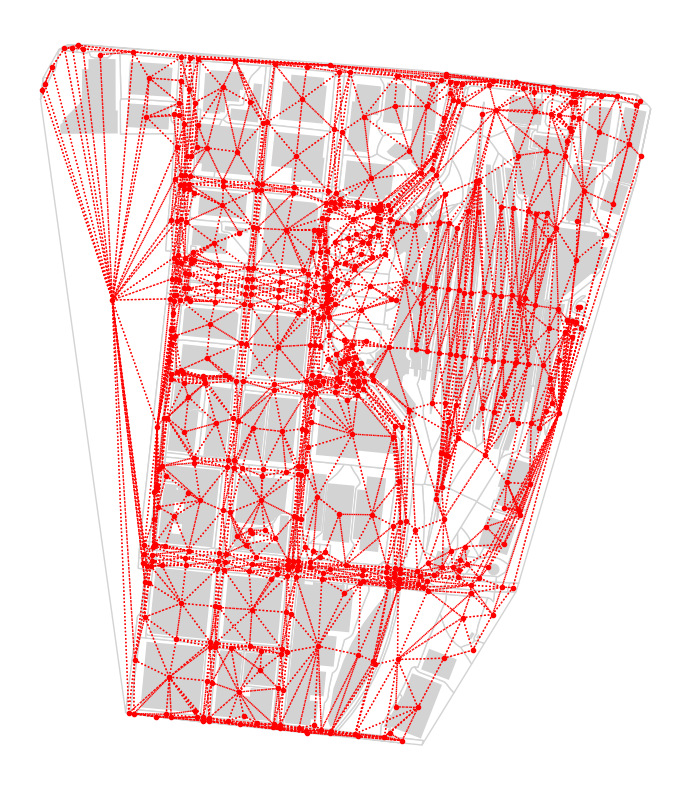

In [503]:
f, ax = plt.subplots(figsize=(10,10))
enclosed_tess.plot(ax=ax, color='white', edgecolor='lightgrey')
buildings.plot(ax=ax, color='lightgrey')
w_queen.plot(enclosed_tess, ax=ax,
            edge_kws=dict(color='r', linestyle=':', linewidth=1),
            node_kws=dict(color='r', marker='.'))

ax.set_axis_off()

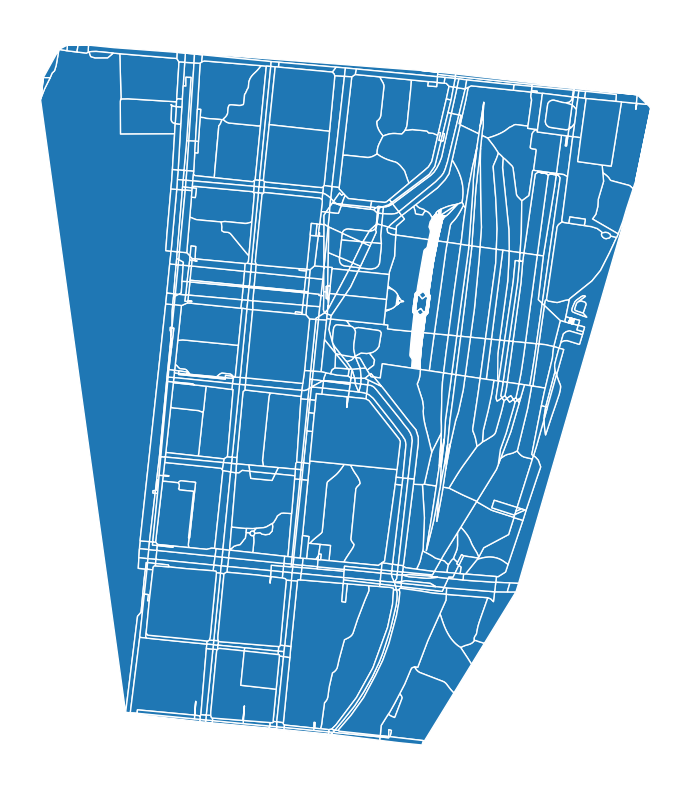

In [510]:
f, ax = plt.subplots(figsize=(10,10))

buildings.plot(ax=ax, color='lightgrey')
#streets.plot(ax=ax, color='lightgrey')
#railways.plot(ax=ax, color='lightgrey')

enclosed_tess.plot(ax=ax, edgecolor='white')

ax.set_axis_off()

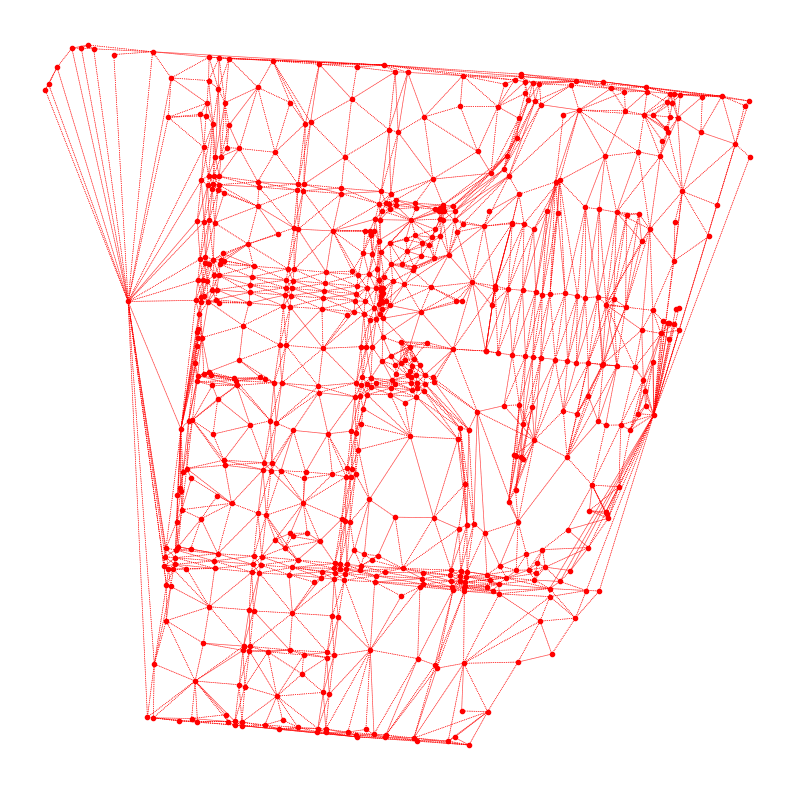

In [505]:
f, ax = plt.subplots(figsize=(10,10))
w_queen.plot(enclosed_tess, ax=ax,
            edge_kws=dict(color='r', linestyle=':', linewidth=0.5),
            node_kws=dict(color='r', marker='.'))

ax.set_axis_off()